# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

***Start with importing libraries.***
---
*Probably need to run "pip install pytrends"*

In [5]:
# import necessary libaries
import pandas as pd
import numpy as np

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset

import warnings
warnings.filterwarnings("ignore")

# Connect to Google
- The first step after installation is to connect Pytrends to Google Trends so that WE can send a request and get the information WE need.
---
The TrendReq receives two important parameters; hl & tz.

hl stands for hosting language for accessing Google Trends; in this example, we set English.

tz stands for timezone

In [42]:
# Configuring connection
trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))
"""Lets see what we can get with trends object"""
trends

# Build Payload
> The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.
---
*kw_list:* list of the target search terms 

*cat:* Category to narrow result fx. Art, Entertainment

*timeframe:* Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'

*geo:* Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World

*gprop:* What Google property to filter to fx. "image" or "news" default to web searches

In [44]:
kw_list = [input("Enter the word that wanna see in Google Trends. >> ")]  # list of keywords to get data 
print(f'you have entered {kw_list}')

# Build playload
trends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo= 'NP', gprop='') 

# lets check if we got the data from google or not?
print(f'Trends object is ready to explore as -> {trends}')

Enter the word that wanna see in Google Trends. >> Balen
you have entered ['Balen']
Trends object is ready to explore as -> <pytrends.request.TrendReq object at 0x7f869f361250>


# What kind of data want to pull? possible methods are:
- Interest Over Time: returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- Interest by Region: returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- Trending Searches: returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [46]:
# Function to Disply in the figure
def displayfig(x, y, title, x_label, y_label, fsize):
    """ The function will take x & value including title, x_label & y_label, & figuresize then display the figure"""
    plt.figure(figsize= fsize)
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

***Interest Over Time***

          date  Balen
256 2022-05-08     61
257 2022-05-15    100
258 2022-05-22     58
259 2022-05-29     25
260 2022-06-05      0


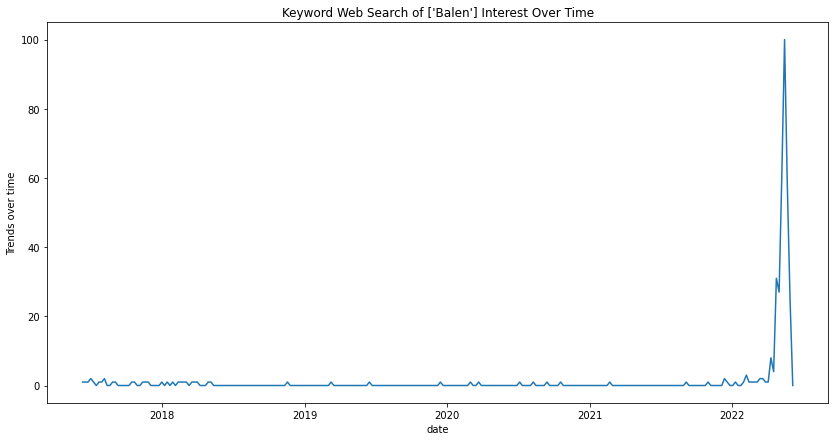

In [47]:
# Interest Over Time
data_over_time= trends.interest_over_time().drop(columns='isPartial')
data_over_time = data_over_time.reset_index()
print(data_over_time.tail())

# Disply in the figure
displayfig(x=data_over_time["date"], y=data_over_time.iloc[:, 1], title= "Keyword Web Search of {kw_list} Interest Over Time".format(kw_list=kw_list), x_label= "date", y_label="Trends over time", fsize= (14, 7))

**Historical Hourly Interest**

The request failed: Google returned a response with code 400.
The request failed: Google returned a response with code 400.
The request failed: Google returned a response with code 400.
The request failed: Google returned a response with code 400.


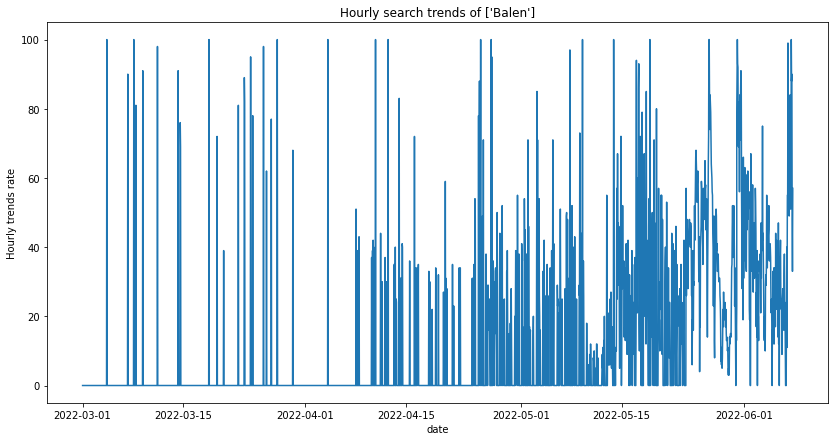

In [41]:
# Historical Hourly Interest (The hourly interest of the keyword)
hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=3, day_start=1, hour_start=0, year_end=2022, month_end=7, day_end=5, hour_end=0)
hourly_trends = hourly_trends.reset_index()

# Disply in the figure
plt.figure(figsize= (14, 7))
plt.plot(hourly_trends["date"], hourly_trends.iloc[:, 1])
plt.title("Hourly search trends of {kw_list}".format(kw_list=kw_list))
plt.xlabel("date")
plt.ylabel("Hourly trends rate")
plt.show()

**Interest by Region(Search by geographical region)**

To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search

*The resolution value is dependent on the geo parameter of the common configuration:*

*Use resolution='COUNTRY' for geo='World'*

*Use resolution='REGION' for geo='US', for example*

In [274]:
# resolution can be either CITY, COUNTRY or REGION
trends_by_region= trends.interest_by_region(resolution='', inc_low_vol=True, inc_geo_code=False)
trends_by_region = trends_by_region.sort_values(by=kw_list, ascending=False)
print(trends_by_region.head(10))


                    Balen
geoName                  
Eastern Region        100
Far-Western Region     91
Mid-Western Region     88
Central Region         80
Western Region         70


**Related Queries**

In [39]:
# Related Queries (keywords that are closely tied to a primary keyword of the choice)
related_queries= trends.related_queries()
related_queries[kw_list[0]]['top']

**Trending topics of the year**

In [235]:
# Trending topics of the year
df= pd.DataFrame()

for year in range(2004, 2022):
    trending = trends.top_charts(year, hl= "en-US", geo= "GLOBAL")
    df[year]= trending.title
    
print(df.head(5))

             2004                  2005             2006  \
0         Ferrari                  iPod   Aaron Spelling   
1             BMW        Digital Camera    Kirby Puckett   
2     Lamborghini            MP3 Player        Jack Wild   
3  Nissan Skyline             iPod Mini  Clifford Geertz   
4         Porsche  PlayStation Portable     Muriel Spark   

                     2007               2008              2009        2010  \
0           American Idol    Joe The Plumber   Michael Jackson        iPad   
1                 YouTube    Jeremiah Wright      Transformers    iPhone 4   
2          Britney Spears           Maverick            Eminem  Nokia 5530   
3  2007 Cricket World Cup      William Ayers  Naruto Shippuden  HTC EVO 4g   
4            Chris Benoit  Bridge To Nowhere           Beyoncé  Nokia N900   

                 2011                2012             2013  \
0  Amazon Kindle Fire  Southwest Airlines  Oscar Pistorius   
1           iPhone 4s     United Airlines  Aar

***Daily trends***
---
*Daily Search Trends highlights searchers that jumped significantly in traffic among all searches over the past 24 hours and update hourly.*
---
*These trends highlight specific queries that were searched, and an absolute number of searches made*


In [253]:
# Get today´s trending topics
trendingtoday = trends.today_searches(pn='DK')
trendingtoday.head()
  

0    /trends/explore?q=MacBook+Air&date=now+7-d&geo=DK
1         /trends/explore?q=Shaman&date=now+7-d&geo=DK
2      /trends/explore?q=Cornelius&date=now+7-d&geo=DK
3        /trends/explore?q=Olaplex&date=now+7-d&geo=DK
4         /trends/explore?q=Weaver&date=now+7-d&geo=DK
Name: exploreLink, dtype: object

**Realtime Trends Searches in a Specific Country**
---
*It highlight stories that are trending across Google surfaces within the last 24 hours and are updated in real-time*

The "pn" argument specifies the geographical location, the US in our example.

In [268]:
# Get realtime Google Trends data
trends_realtime= trends.trending_searches(pn='denmark')
trends_realtime.head(10)

#df = trends.realtime_trending_searches(pn='denmark')
#df.head(10)

,0
0,MacBook Air
1,Shaman
2,Cornelius
3,Olaplex
4,Weaver
5,USB-C
6,Nations League
7,Denmark vs Austria
8,Boris Johnson
9,Apple
